# 実データを使ってPSDを求める

- 北海道大学・大学院理学院の海洋気候物理学研究室のHPに，スペクトル解析に関するpdfがありました．とても参考になると思う．
https://www.sci.hokudai.ac.jp/~minobe/data_anal

- ウェルチのパワースペクトル密度関数
https://jp.mathworks.com/help/signal/ug/nonparametric-methods.html#f12-20691

- FFT を使用したパワー スペクトル密度推定
https://jp.mathworks.com/help/signal/ug/power-spectral-density-estimates-using-fft.html

- Python: SciPy のパワースペクトル密度推定の関数
https://org-technology.com/posts/power-spectral-density.html
- PythonでFFT
https://watlab-blog.com/2019/04/21/python-fft/
- Scipy.signal.welch
https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html
- わかりやすくまとまってる
http://climbsd.lowtem.hokudai.ac.jp/group/shigeru/tc/dataan2012/num5.pdf

In [1]:
import scipy
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import pandas as pd

In [23]:
data= pd.read_csv('RAW_Gyro_201701080900min_to_59min.csv', encoding='shift_jis',index_col=0)#RAW_Gyro_201701080900min_to_59min#RawStr_HMS_201701080920min_to_20min
X = data.values[:,0]
print(np.shape(X))

(35921,)


In [24]:
N =len(X)        # サンプル数  2^15=32768 , 2^14=16384
fs=10           #サンプリング周波数
dt =1/fs       # サンプリング間隔
t = np.arange(0.0, N*dt, dt) # 時間軸
freq = np.linspace(0, 1.0/dt,N)#rad/s
fn=1/dt/2     #ナイキスト周波数
Hp=0.5        #[Hz]:ハイパスフィルタの周波数
Lp=0.04       #[Hz]:ローパスフィルタの周波数

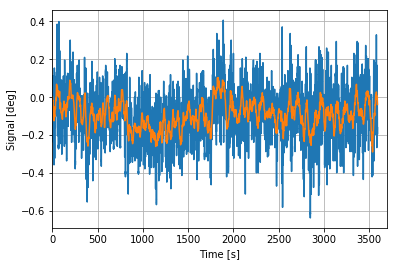

236.3040249739977


In [25]:
"""時系列データを描画"""
plt.figure()
plt.plot(t,X, label='X(t)')

"""移動平均作成"""
conv1 = np.ones(200)/200 # 移動平均をとるための配列vを設定。今回は前後５つの値を用いて平均をとる。
X_2 = np.convolve(X, conv1, mode='same')  # グラフを描く都合上'same'で。
plt.plot(t,X_2)

plt.xlabel("Time [s]")
plt.ylabel("Signal [deg]")
#leg = plt.legend(loc=1, fontsize=15)
plt.grid()
plt.xlim(0,3700)
plt.show()

"""時間領域の全エネルギー"""
print(np.sum(X**2)*(2**13/len(X)))

### トレンド除去

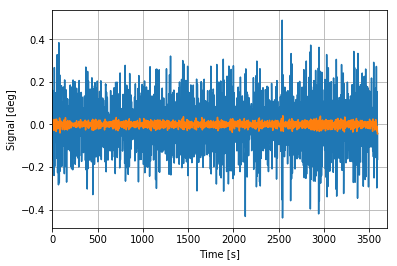

35921
115.9856792298552


In [26]:
"""フーリエ変換"""
F =np.fft.fft(X)/N*2  

"""周波数カットしてから逆フーリエ変換"""
#F_1[(freq>=fn)]=0  #ナイキスト周波数以降はカット
F[(freq>=Hp)]=0
F[(freq<=Lp)]=0
X=np.real(np.fft.ifft(F)*N)
plt.plot(t,X)

"""移動平均作成"""
conv1 = np.ones(200)/200 # 移動平均をとるための配列vを設定。今回は前後５つの値を用いて平均をとる。
X_2 = np.convolve(X, conv1, mode='same')  # グラフを描く都合上'same'で。
plt.plot(t,X_2)

"""描画"""
plt.xlabel("Time [s]")
plt.ylabel("Signal [deg]")
plt.xlim(0,3700)
plt.grid()
plt.show()
"""時間領域の全エネルギー パーセバルの定理"""
print(len(X))
print(np.sum(X**2)*(2**13/len(X)))

### 各セグメントにデータウィンドウを掛けてFFT
- https://jp.mathworks.com/help/matlab/ref/fft.html
- hannnigによる振幅補正係数はhttps://ecd-assist.com/wp/wp-content/uploads/2017/04/%E7%AA%93%E9%96%A2%E6%95%B0%E3%81%AE%E5%BD%B1%E9%9F%BF.pdf

In [29]:
"""オーバーラップ処理のスライド条件"""
framesize=2**13  #2^15=32768 , 2^14=16384 , 2^13=8192
slide_size=100
t_frame    = np.arange(0.0, framesize*dt, dt)
freq_frame = np.linspace(0, 1.0/dt, framesize) 

"""hanning window"""
hanning=np.array([0.5-0.5*np.cos(2*np.pi/(framesize-1)*i) for i in range(framesize)]) #窓関数:hamming window
correction_factor=1/0.5019   #テーパーによる低下の補正係数

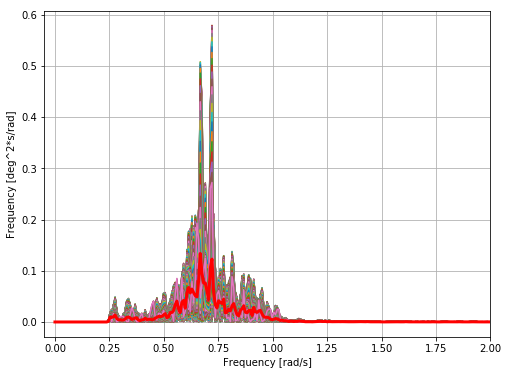

277
(4097,)


In [30]:
"""オーバーラップ処理"""
plt.figure(figsize=(8,6))
PSD_all=np.zeros(int(framesize/2)+1)
count=0
for i in range(int((N-framesize)/slide_size)):
    count+=1
    X_taper=X[i*slide_size : i*slide_size+framesize]*hanning
    F=np.fft.fft(X_taper)*correction_factor
        
    PSD=(np.abs(F)[0:int(framesize/2)+1])**2/(framesize*fs)/(2*np.pi)
    PSD[1:int(framesize/2)-1]=2*PSD[1:int(framesize/2)-1].copy()
    plt.plot(freq_frame[0:int(framesize/2)+1]*2*np.pi,PSD)
    
    PSD_all+=PSD
PSD_mean=PSD_all/int((N-framesize)/slide_size)#np.mean(F_all,axis=0)#

plt.plot(freq_frame[0:int(framesize/2)+1]*2*np.pi,PSD_mean,linewidth=3,color='red')
plt.grid()
plt.xlim(-0.05,2)
plt.xlabel("Frequency [rad/s]")
plt.ylabel("Frequency [deg^2*s/rad]")
plt.show()
print(count)
print(np.shape(PSD_mean))
#np.sum(PSD_mean[0:int(framesize/2)+1]**2)*2/framesize #パーセバルの定理確認

### 直接スペクトル法(Periodogram法)のあと(平滑化)
- https://jp.mathworks.com/help/signal/ug/power-spectral-density-estimates-using-fft.html

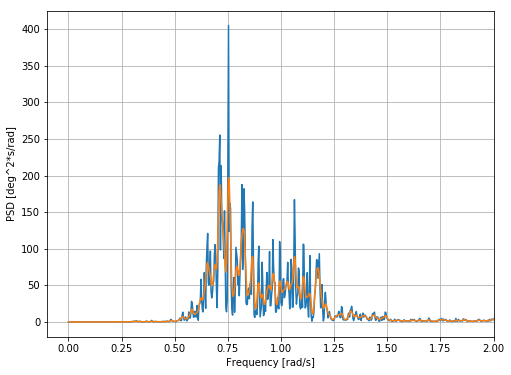

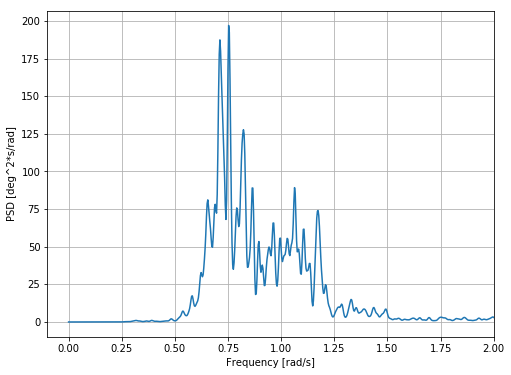

In [22]:
plt.figure(figsize=(8,6))
"""Smoothing 3点移動平均を4重にかけて平滑化"""
conv2 = np.ones(3)/3 # 移動平均をとるための配列vを設定。今回は前後５つの値を用いて平均をとる。
PSD1 = np.convolve(PSD_mean, conv2, mode='same')  # グラフを描く都合上'same'で。
PSD1 = np.convolve(PSD1, conv2, mode='same')
PSD1 = np.convolve(PSD1, conv2, mode='same')
PSD1 = np.convolve(PSD1, conv2, mode='same')
plt.plot(freq_frame[0:int(framesize/2)+1]*2*np.pi,PSD_mean)
plt.plot(freq_frame[0:int(framesize/2)+1]*2*np.pi,PSD1)
plt.xlim(-0.1,2)
plt.xlabel("Frequency [rad/s]")
plt.ylabel("PSD [deg^2*s/rad]")
plt.grid()
plt.show()

plt.figure(figsize=(8,6))
plt.plot(freq_frame[0:int(framesize/2)+1]*2*np.pi,PSD1)
plt.xlim(-0.1,2)
plt.xlabel("Frequency [rad/s]")
plt.ylabel("PSD [deg^2*s/rad]")
plt.grid()
plt.show()

(0, 2)

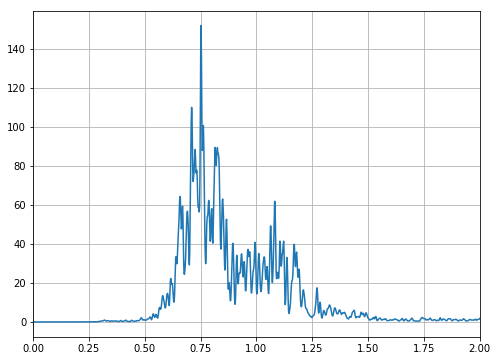

In [20]:
plt.figure(figsize=(8,6))
freq4,welchpsd=signal.periodogram(X,fs)
conv2 = np.ones(3)/3
welchpsd = np.convolve(welchpsd, conv2, mode='same')  # グラフを描く都合上'same'で。
welchpsd = np.convolve(welchpsd, conv2, mode='same')
welchpsd = np.convolve(welchpsd, conv2, mode='same')
welchpsd= np.convolve(welchpsd, conv2, mode='same')
plt.plot(freq4*2*np.pi,welchpsd/(2*np.pi))
plt.grid()
plt.xlim(0,2)